<a href="https://colab.research.google.com/github/pavi-ninjaac/Specrom_Analysis/blob/main/Internship_works/week3/text_classification_109.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
#get the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
#sklearn functions
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

#sklearn vectorization packages
from sklearn.feature_extraction.text import TfidfVectorizer

#sklearn models
from sklearn.linear_model import LogisticRegression

#sklearn evaluation metrics
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

In [95]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataFiles/Text_classification_news_article/rishika_csv_different_computer_with_iptc.csv',index_col=0)

shape = data.shape
columns = list(data.columns)

print("the shape of the dataset is--->",shape)
print('The features are-------------->',columns)

data.head(4)


the shape of the dataset is---> (10761, 8)
The features are--------------> ['position', 'query', 'url', 'title', 'snippet', 'combined_text', 'level1_labels', 'level2_labels']


,position,query,url,title,snippet,combined_text,level1_labels,level2_labels
0,1,"arts, culture, entertainment and media",https://www.bbc.com/news/entertainment_and_arts,Entertainment & Arts - BBC News,Get the latest BBC Entertainment and Arts news...,Entertainment & Arts - BBC News Get the latest...,"arts, culture, entertainment and media",NaN
1,2,"arts, culture, entertainment and media",https://www.champaigncounty.org/list/ql/arts-c...,"Arts, Culture & Entertainment | Champaign Coun...",Champaign County Chamber of Commerce - IL 303 ...,"Arts, Culture & Entertainment | Champaign Coun...","arts, culture, entertainment and media",NaN
2,3,"arts, culture, entertainment and media",https://www.bls.gov/oes/current/oes270000.htm,"Arts, Design, Entertainment, Sports, and Media...","27-0000 Arts, Design, Entertainment, Sports, a...","Arts, Design, Entertainment, Sports, and Media...","arts, culture, entertainment and media",NaN
3,4,"arts, culture, entertainment and media",https://www.smc.edu/academics/areas-of-interes...,"Arts, Media, & Entertainment - Santa Monica Co...",Let your imagination run wild and free — explo...,"Arts, Media, & Entertainment - Santa Monica Co...","arts, culture, entertainment and media",NaN


In [96]:
print("The nunber of category----------->",data['level1_labels'].nunique())
print("The nunber of second category---->",data['level2_labels'].nunique())

The nunber of category-----------> 17
The nunber of second category----> 109


In [97]:
print("The nunber of quieries---->",data['query'].nunique())

The nunber of quieries----> 1296


In [98]:
data['position'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [99]:
needed_columns = ['combined_text','query','level1_labels','level2_labels']
data = data[needed_columns].copy()
data.head(4)

,combined_text,query,level1_labels,level2_labels
0,Entertainment & Arts - BBC News Get the latest...,"arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
1,"Arts, Culture & Entertainment | Champaign Coun...","arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
2,"Arts, Design, Entertainment, Sports, and Media...","arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
3,"Arts, Media, & Entertainment - Santa Monica Co...","arts, culture, entertainment and media","arts, culture, entertainment and media",NaN


# Handling dublicate values

In [100]:
#delete the dublicate values
data.duplicated().sum() # count the total duplicate samples

362

In [101]:
data.drop_duplicates(keep='last',inplace=True)

In [102]:

#there can be dublicate of author names so check for the dublicate headline and short discription
data.duplicated(subset=[ 'combined_text']).sum()

751

In [103]:
data.drop_duplicates(subset='combined_text' , keep ='last' , inplace=True)

In [104]:
print("THe length of the datset after dublicate deletion------>",data.shape)

THe length of the datset after dublicate deletion------> (9648, 4)


# Handling null values

In [105]:
data.isnull().sum()

combined_text      1
query              0
level1_labels      0
level2_labels    133
dtype: int64

 for now i am deleting only the null values in the 'combined_text' column, later when i am dealing with lavel2_labels, i will handle that null values

In [106]:
data.dropna(subset =['combined_text'],axis=0 ,inplace=True , how='any')

In [107]:
print("THe length of the datset after null values deletion------>",data.shape)

THe length of the datset after null values deletion------> (9647, 4)


In [108]:
data[data['combined_text'] == ' ']
data = data.reset_index()
data = data.drop('index',axis=1)
data.head(4)

,combined_text,query,level1_labels,level2_labels
0,"Arts, Culture & Entertainment | Champaign Coun...","arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
1,"Arts, Design, Entertainment, Sports, and Media...","arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
2,"Arts, Media, & Entertainment - Santa Monica Co...","arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
3,Arts and Entertainment Management College Degr...,"arts, culture, entertainment and media","arts, culture, entertainment and media",NaN


# Cleaning the combined text

In [109]:
def preprocessor_text(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', ' ', text)
        text = re.sub('[\W]+', ' ', text.lower())
        return text
    if isinstance((text), (list)):
        return_list = []
        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            return_list.append(temp_text)
        return(return_list)

data['combined_text'] = data['combined_text'].apply(preprocessor_text)

data.head(4)

,combined_text,query,level1_labels,level2_labels
0,arts culture entertainment champaign county ch...,"arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
1,arts design entertainment sports and media occ...,"arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
2,arts media entertainment santa monica college ...,"arts, culture, entertainment and media","arts, culture, entertainment and media",NaN
3,arts and entertainment management college degr...,"arts, culture, entertainment and media","arts, culture, entertainment and media",NaN


# Balance the dataset

In [110]:
#helper functions
def downsample(df , label):
  g = df.groupby(label , group_keys=False)
  balaced_df = pd.DataFrame(g.apply(lambda x : x.sample(g.size().min()))).reset_index(drop=True)
  return balaced_df


def balace_category(data , category_column , downsample_value):
  #to handle the categories easily, we have to change the dtype of the 'query' to category
  data[category_column] = data[category_column].astype('category')

  category = data[category_column].value_counts().index
  print("The shape before deletion------------------------------------------>",data.shape)
  print()
  print("The number of category in the {} column------------------------->{}".format(category_column , len(category)))

  #seperate the column which has to be delete
  need_to_be_deleted = category[(data[category_column].value_counts() < downsample_value)]
  print("The number of category need to be deleted in the {} column------>{}".format(category_column , len(need_to_be_deleted)))

  #delete the unwanted category
  data[category_column] = data[category_column].cat.remove_categories(need_to_be_deleted) #set nan for the categories need to be deletd and then use dropna to delete those things
  data.dropna(axis=0 , how='any',inplace=True) #delete the nan category

  print("The number of category after deletion------------------------------>",len(data[category_column].value_counts().index))
  print()
  print("The shape after deletion------------------------------------------->",data.shape)
  print()

  #down sample the query category to its minimum value
  data = downsample(data , category_column) #call the helper function
  #data[category_column].value_counts()

  #saffule the dataset
  data = shuffle(data)
  data.reset_index(inplace=True, drop=True) 
  

  return data

In [111]:
#for my understanding- if you cant understand the healper function , uncommend this and try each parts seperately, you will get a clear idea of what is happening
"""
#part-1
#to handle the categories easily, we have to change the dtype of the 'query' to category
data_query['query'] = data_query['query'].astype('category')

#part-2
query_category = data_query['query'].value_counts().index
print("The shape before deletion------------------------------------------>",data_query.shape)
print()
print("The number of category in the query column------------------------->",len(query_category))

#seperate the column which has to be delete
need_to_be_deleted = query_category[(data_query['query'].value_counts()<6)]
print("The number of category need to be deleted in the query column------>",len(need_to_be_deleted))

#delete the unwanted category
data_query['query'] = data_query['query'].cat.remove_categories(need_to_be_deleted) #set nan for the categories need to be deletd and then use dropna to delete those things
data_query.dropna(axis=0 , how='any',inplace=True) #delete the nan category

print("The number of category after deletion------------------------------>",len(data_query['query'].value_counts().index))
print()
print("The shape after deletion------------------------------------------->",data_query.shape)
print()

#part-3
#down sample the query category to its minimum value
data_query = downsample(data_query , 'query')
data_query['query'].value_counts()"""


'\n#part-1\n#to handle the categories easily, we have to change the dtype of the \'query\' to category\ndata_query[\'query\'] = data_query[\'query\'].astype(\'category\')\n\n#part-2\nquery_category = data_query[\'query\'].value_counts().index\nprint("The shape before deletion------------------------------------------>",data_query.shape)\nprint()\nprint("The number of category in the query column------------------------->",len(query_category))\n\n#seperate the column which has to be delete\nneed_to_be_deleted = query_category[(data_query[\'query\'].value_counts()<6)]\nprint("The number of category need to be deleted in the query column------>",len(need_to_be_deleted))\n\n#delete the unwanted category\ndata_query[\'query\'] = data_query[\'query\'].cat.remove_categories(need_to_be_deleted) #set nan for the categories need to be deletd and then use dropna to delete those things\ndata_query.dropna(axis=0 , how=\'any\',inplace=True) #delete the nan category\n\nprint("The number of category a

In [112]:
#healper function
label = LabelEncoder()

def split_and_tfidfVectorization(X , y , max_df , min_df):

  #label the y value
  y = label.fit_transform(y)
  #split the dataset
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

  #tfidf
  vecto =  TfidfVectorizer(stop_words='english',max_df = max_df ,min_df= min_df,
                                   ngram_range=(1, 2),lowercase=True, max_features=5000)
  vecto = vecto.fit(X_train)

  X_train = vecto.transform(X_train).toarray()
  X_test = vecto.transform(X_test).toarray()

  #print the shapes
  print("The shape of the X train----------->",X_train.shape)
  print("The shape of the y train----------->",y_train.shape)
  print("The shape of the X test------------>",X_test.shape)
  print("The shape of the y test------------>",y_test.shape)

  return X_train,X_test,y_train,y_test,vecto

# Model training

In [113]:
def classifier_scores(y_train,y_test, pred_train, pred_test):
    
    print()
    print("Train data accuracy score: ", accuracy_score(y_train,pred_train))    
    print("Test data accuracy score: ", accuracy_score(y_test,pred_test))
    print()
    print("Recall score on train data: ", recall_score(y_train,pred_train, average='macro'))
    print("Recall score on test data: ",recall_score( y_test,pred_test, average='macro'))
    print()
    
    print("Precision score on train data: ",precision_score(y_train,pred_train, average='macro'))
    print("Precision score on test data: ",precision_score(y_test,pred_test, average='macro'))
    print()
    print("F1 score on train data: ",f1_score(y_train,pred_train, average='macro'))
    print("F1 score on test data: ",f1_score(y_test,pred_test, average='macro'))

# Logistric Regression

In [114]:
def logistricRegression( X_train,X_test,y_train,y_test):
  log_reg = LogisticRegression()

  log_reg.fit(X_train , y_train)

  y_train_pred = log_reg.predict(X_train)
  y_test_pred = log_reg.predict(X_test)

  classifier_scores(y_train,y_test,y_train_pred,y_test_pred) #call the healper function

  return log_reg

### 'query' categories

- When doing the balancing , we have to delete the categorie, which are having very few sample. Here by i am deleting the categories which are having less than 6 sample. 
- after deletion, we have to resample the data by select 6 samples randomly from each categories. 

In [115]:
#copy the original data 
data2 = data.copy()
data_query = data[['combined_text' , 'query']].copy()

#balace the dataset according to 'query' column
print('-'*50)
print("Balancing the data------")
data_query = balace_category(data = data_query , category_column= 'query' , downsample_value= 6)

--------------------------------------------------
Balancing the data------
The shape before deletion------------------------------------------> (9647, 2)

The number of category in the query column------------------------->1296
The number of category need to be deleted in the query column------>254
The number of category after deletion------------------------------> 1042

The shape after deletion-------------------------------------------> (8570, 2)



In [116]:
X = data_query['combined_text']
y = data_query['query']

X_train,X_test,y_train,y_test,vecto_query = split_and_tfidfVectorization(X,y , max_df = 0.99 , min_df = 6)

The shape of the X train-----------> (5001, 4585)
The shape of the y train-----------> (5001,)
The shape of the X test------------> (1251, 4585)
The shape of the y test------------> (1251,)


In [117]:
# train the logistric regression model
log_reg_query = logistricRegression(X_train,X_test,y_train,y_test)


Train data accuracy score:  0.8922215556888622
Test data accuracy score:  0.3796962430055955

Recall score on train data:  0.861724248240563
Recall score on test data:  0.38473684210526315

Precision score on train data:  0.8852524900989391
Precision score on test data:  0.3419135338345865

F1 score on train data:  0.8560690564596187
F1 score on test data:  0.3390083542188805


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Level1_label classification

In [118]:
# set the dataset
data_lavel1 = data[['combined_text' , 'level1_labels']]

#check fot the downsample value
data_lavel1['level1_labels'].value_counts()

sport                                        2424
economy, business and finance                1950
politics                                      765
arts, culture, entertainment and media        544
crime, law and justice                        486
health                                        458
science and technology                        432
religion and belief                           429
society                                       411
lifestyle and leisure                         406
labour                                        265
disaster, accident and emergency incident     241
conflict, war and peace                       231
environment                                   225
education                                     197
human interest                                144
weather                                        39
Name: level1_labels, dtype: int64

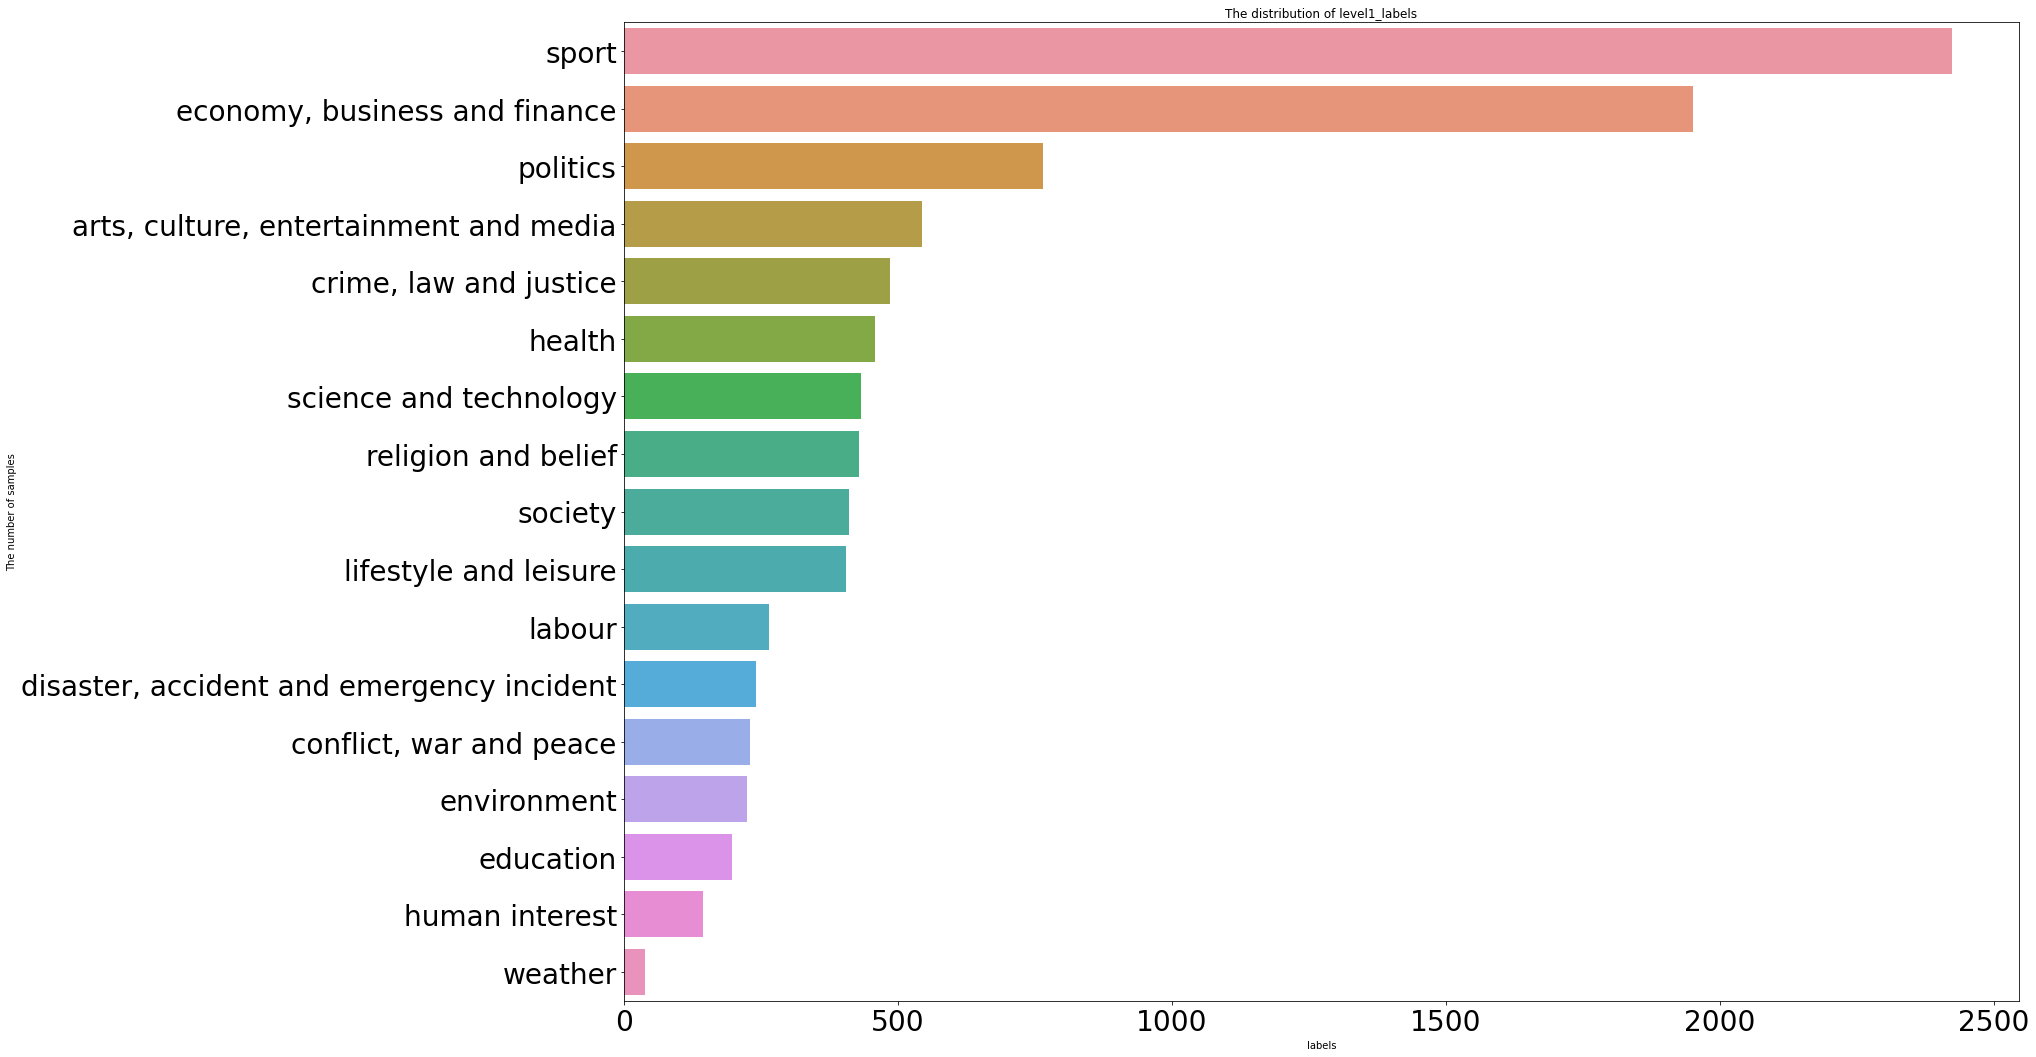

In [119]:
data_labbel1_category = data_lavel1['level1_labels'].value_counts()

plt.figure(figsize=(25,18)) 

sns.barplot(y = data_labbel1_category.index , x=data_labbel1_category.values , )

plt.title("The distribution of level1_labels")
plt.xlabel("labels")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 28)
plt.xticks(rotation=0,fontsize = 28)
plt.show()
#plt.savefig(r"./author_bar.png")

## Model training with out category balancing

In [120]:
# train the model with out data balancing
X = data_lavel1['combined_text']
y = data_lavel1['level1_labels']
print('The lenth of the dataset',len(X))
print()
print()
print('-'*50)
print('Spliting and Vectorizing the dataset')
X_train,X_test,y_train,y_test,vecto_level1 = split_and_tfidfVectorization(X,y , max_df = 0.99 , min_df = 8)

#train and eveluate the model
print('-'*50)
print("Training the model.......................")
log_reg_level1 = logistricRegression(X_train,X_test,y_train,y_test)

The lenth of the dataset 9647


--------------------------------------------------
Spliting and Vectorizing the dataset
The shape of the X train-----------> (7717, 5000)
The shape of the y train-----------> (7717,)
The shape of the X test------------> (1930, 5000)
The shape of the y test------------> (1930,)
--------------------------------------------------
Training the model.......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Train data accuracy score:  0.8960736037320202
Test data accuracy score:  0.7772020725388601

Recall score on train data:  0.8169409681167947
Recall score on test data:  0.6408217519903738

Precision score on train data:  0.9427309456765781
Precision score on test data:  0.866525294651324

F1 score on train data:  0.8689008605995892
F1 score on test data:  0.7194082611612839


## Model trainig with category balancing

In [121]:
#balace the dataset according to 'level1_labels' column
print('-'*50)
print("Balancing the data------")
data_query = balace_category(data = data_lavel1 , category_column= 'level1_labels' , downsample_value= 237)

#split and Vectorize
print('-'*50)
print('Spliting and Vectorizing the dataset')
X_train,X_test,y_train,y_test,vecto_level1 = split_and_tfidfVectorization(X,y , max_df = 0.99 , min_df = 7)

#train and eveluate the model
print('-'*50)
print("Training the model.......................")
log_reg_level1_balanced = logistricRegression(X_train,X_test,y_train,y_test)

--------------------------------------------------
Balancing the data------
The shape before deletion------------------------------------------> (9647, 2)

The number of category in the level1_labels column------------------------->17
The number of category need to be deleted in the level1_labels column------>5
The number of category after deletion------------------------------> 12

The shape after deletion-------------------------------------------> (8811, 2)

--------------------------------------------------
Spliting and Vectorizing the dataset


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

The shape of the X train-----------> (7717, 5000)
The shape of the y train-----------> (7717,)
The shape of the X test------------> (1930, 5000)
The shape of the y test------------> (1930,)
--------------------------------------------------
Training the model.......................

Train data accuracy score:  0.9013865491771413
Test data accuracy score:  0.7818652849740932

Recall score on train data:  0.8231215451332111
Recall score on test data:  0.6485010283248824

Precision score on train data:  0.9457057391716359
Precision score on test data:  0.8698027272027391

F1 score on train data:  0.8739776044146459
F1 score on test data:  0.7258931022448721


# 'level2_labels' category

In [122]:
# set the dataset
data_lavel2 = data[['combined_text' , 'level2_labels']].copy()

#check fot the downsample value
data_lavel2['level2_labels'].value_counts()

competition discipline                        2213
economic sector                               1183
arts and entertainment                         425
economy                                        343
leisure                                        305
                                              ... 
non-governmental organisation                    5
bodybuilding                                     4
sport industry                                   4
religious institutions and state relations       4
religious education                              4
Name: level2_labels, Length: 109, dtype: int64

In [123]:
# handling the null values
data_lavel2.isnull().sum()

combined_text      0
level2_labels    133
dtype: int64

In [124]:
data_lavel2.dropna(axis=0 ,inplace =True , how ='any')
print('The shape of the dataset-------------->',data_lavel2.shape)

The shape of the dataset--------------> (9514, 2)


In [125]:
category_count = list(data_lavel2['level2_labels'].value_counts().values)
#category_count  # 2213 --->206-->121--->90-->83--->67--->54-->44--->39--->20....>10...11...6..7..5..4..

## Model training without data balancing

In [126]:
# train the model with out data balancing
X = data_lavel2['combined_text']
y = data_lavel2['level2_labels']
print('The lenth of the dataset',len(X))
print()
print()
print('-'*50)
print('Spliting and Vectorizing the dataset')
X_train,X_test,y_train,y_test,vecto_level2 = split_and_tfidfVectorization(X,y , max_df = 0.99 , min_df = 8)

#train and eveluate the model
print('-'*50)
print("Training the model.......................")
log_reg_level2 = logistricRegression(X_train,X_test,y_train,y_test)

The lenth of the dataset 9514


--------------------------------------------------
Spliting and Vectorizing the dataset
The shape of the X train-----------> (7611, 4962)
The shape of the y train-----------> (7611,)
The shape of the X test------------> (1903, 4962)
The shape of the y test------------> (1903,)
--------------------------------------------------
Training the model.......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Train data accuracy score:  0.7658651951123374
Test data accuracy score:  0.6111403047819233

Recall score on train data:  0.3510001526213705
Recall score on test data:  0.2526907948997323

Precision score on train data:  0.5757070328752937
Precision score on test data:  0.4641971674788409

F1 score on train data:  0.41073756701095104
F1 score on test data:  0.302060511496685


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model training with Data Balancing


In [127]:
#balace the dataset according to 'level1_labels' column
print('-'*100)
print("Balancing the data------")
data_query = balace_category(data = data_lavel2 , category_column= 'level2_labels' , downsample_value= 39)

#split and Vectorize
print('-'*100)
print('Spliting and Vectorizing the dataset')
X_train,X_test,y_train,y_test,vecto_level2_balanced = split_and_tfidfVectorization(X,y , max_df = 0.99 , min_df = 7)

#train and eveluate the model
print('-'*100)
print("Training the model.......................")
log_reg_level2_balanced = logistricRegression(X_train,X_test,y_train,y_test)

--------------------------------------------------
Balancing the data------
The shape before deletion------------------------------------------> (9514, 2)

The number of category in the level2_labels column------------------------->109
The number of category need to be deleted in the level2_labels column------>58
The number of category after deletion------------------------------> 51

The shape after deletion-------------------------------------------> (8798, 2)

--------------------------------------------------
Spliting and Vectorizing the dataset
The shape of the X train-----------> (7611, 5000)
The shape of the y train-----------> (7611,)
The shape of the X test------------> (1903, 5000)
The shape of the y test------------> (1903,)
--------------------------------------------------
Training the model.......................

Train data accuracy score:  0.7745368545526212
Test data accuracy score:  0.6163951655281135

Recall score on train data:  0.3620654645734757
Recall score on te

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
